In [1]:
library(tidyverse)
library(ggplot2)
library(rstatix)
library(ggrepel)
library(metap)
library(dplyr)

Warning message:
“package ‘tidyverse’ was built under R version 4.3.3”
Warning message:
“package ‘tibble’ was built under R version 4.3.3”
Warning message:
“package ‘tidyr’ was built under R version 4.3.3”
Warning message:
“package ‘readr’ was built under R version 4.3.3”
Warning message:
“package ‘purrr’ was built under R version 4.3.3”
Warning message:
“package ‘dplyr’ was built under R version 4.3.3”
Warning message:
“package ‘stringr’ was built under R version 4.3.3”
Warning message:
“package ‘forcats’ was built under R version 4.3.3”
Warning message:
“package ‘lubridate’ was built under R version 4.3.3”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()

In [2]:
color_annotation<-read.csv('/home//workspace/IHA_Figure_Revision/Color_hex_codes/Cell_Type_Color_Annotation_and_Order.csv')
color_vector <- setNames(color_annotation$color, color_annotation$label)

# Read Freq Change Result for CMV Comparison


In [3]:
df_BRI<-read.csv("01_Freq_Changes_Y1D0_CMV_BRI/FreqChanges_and_DEG_Y1D0.csv")
df_SF4<-read.csv("02_Freq_Changes_and_DEG_CMV_SF4/DEG_counts_and_Frequency_Changes.csv")

In [4]:
df_BRI_filtered<-df_BRI %>% select(AIFI_L3,delta_change,p.adj)
df_SF4_filtered<-df_SF4 %>% select(AIFI_L3,delta_change,p.adj)

In [5]:
colnames(df_BRI_filtered)<-c('AIFI_L3','BRI_delta_change','BRI_p.adj')
colnames(df_SF4_filtered)<-c('AIFI_L3','SF4_delta_change','SF4_p.adj')

In [6]:
df_combined<-left_join(df_BRI_filtered,df_SF4_filtered)

df_combined <- df_combined %>%
  rowwise() %>%
  mutate(fisher_p = sumlog(c(BRI_p.adj, SF4_p.adj))$p) %>%
  ungroup()

Joining with `by = join_by(AIFI_L3)`


In [7]:
df_combined <- df_combined %>%
  rowwise() %>%
  mutate(fisher_p = sumlog(c_across(c(BRI_p.adj, SF4_p.adj)))$p) %>%
  ungroup()

# Plotting

In [8]:
labels_vector<-c("Adaptive NK cell", 'KLRF1- GZMB+ CD27- memory CD4 T cell','KLRF1- GZMB+ CD27- EM CD8 T cell','KLRF1+ GZMB+ CD27- EM CD8 T cell',
                 'KLRF1+ effector Vd1 gdT', 'KLRF1- effector Vd1 gdT')

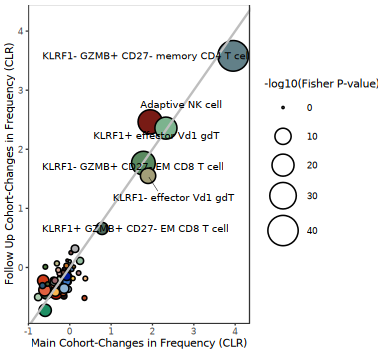

In [16]:
options(repr.plot.width = 80/25.4, repr.plot.height = 75/25.4)


p<-ggplot(df_combined,aes(x=BRI_delta_change, y=SF4_delta_change, size =-log10(fisher_p), fill=AIFI_L3)) +
    geom_point(shape = 21, colour = "black") +
    geom_abline( color = "gray", size = 0.5) +
    xlab('Main Cohort-Changes in Frequency (CLR)') +
    ylab('Follow Up Cohort-Changes in Frequency (CLR)') +
    scale_fill_manual(values = color_vector) +
    guides(fill = "none", size = guide_legend("-log10(Fisher P-value)")) + 
  geom_text_repel(
    data = df_combined %>% filter(AIFI_L3 %in% labels_vector),
    box.padding = 0.5,
    force = 0.5,
    max.overlaps = 50,
    nudge_x = 0.15,
    hjust = 0.1,
    segment.size = 0.1,
    mapping = aes(label = AIFI_L3),
    size = 2
  ) +
    theme_bw(base_size=6)+
  theme(
    panel.grid.major = element_blank(), 
    panel.grid.minor = element_blank() 
  )+
  scale_y_continuous(expand = expansion(mult = c(0.05, 0.2)))+
  scale_size_continuous(range = c(0, 8), limits = c(0, max(-log10(df_combined$fisher_p))) )
p
ggsave(filename = "FigureA.pdf", plot = p, width = 80/25.4, height = 7/25.4)
